### Import Libraries

In [100]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [101]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_sub=pd.read_csv('sample_submission.csv')
df_org=pd.read_csv('Churn_Modelling.csv')

In [102]:
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler()
# scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
# for col in scale_cols:
#     df_train[col+"_scaled"]=scaler.fit_transform(df_train[col].values.reshape(-1,1)) # (-1,1) is for reshaping the array to 2D
#     df_test[col+"_scaled"]=scaler.transform(df_test[col].values.reshape(-1,1))

scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

In [103]:
df_train.head().T

,0,1,2,3,4
id,0,1,2,3,4
CustomerId,15674932,15749177,15694510,15741417,15766172
Surname,Okwudilichukwu,Okwudiliolisa,Hsueh,Kao,Chiemenam
CreditScore,668,627,678,581,716
Geography,France,France,France,France,Spain
Gender,Male,Male,Male,Male,Male
Age,33.0,33.0,40.0,34.0,33.0
Tenure,3,1,10,2,5
Balance,0.0,0.0,0.0,148882.54,0.0
NumOfProducts,2,2,2,1,2


### Feature Engineering

In [104]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')
    
    return df

In [105]:
df_train = getFeats(df_train)
df_test = getFeats(df_test)
##
feat_cols=df_train.columns.drop(['id','Exited'])
feat_cols=feat_cols.drop(scale_cols)
print(feat_cols)
df_train.head()

Index(['CustomerId', 'Surname', 'Geography', 'Gender', 'Tenure',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'IsSenior', 'IsActive_by_CreditCard', 'Products_Per_Tenure', 'AgeCat',
       'Sur_Geo_Gend_Sal'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Exited,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure,AgeCat,Sur_Geo_Gend_Sal
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0,0.202703,0.636,0.000000,0.907279,0,0.0,1.5,2,OkwudilichukwuFranceMale181450.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,0,0.202703,0.554,0.000000,0.247483,0,1.0,0.5,2,OkwudiliolisaFranceMale49504.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,0,0.297297,0.656,0.000000,0.924364,0,0.0,5.0,2,HsuehFranceMale184867.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,0,0.216216,0.462,0.593398,0.422787,0,1.0,2.0,2,KaoFranceMale84561.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,0,0.202703,0.732,0.000000,0.075293,0,1.0,2.5,2,ChiemenamSpainMale15069.0


In [106]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,165034.0,8.251650e+04,47641.356500,0.00,4.125825e+04,8.251650e+04,1.237748e+05,165033.00
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,1.563314e+07,1.569017e+07,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,5.970000e+02,6.590000e+02,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,3.200000e+01,3.700000e+01,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.000000e+00,5.000000e+00,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.000000e+00,0.000000e+00,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.000000e+00,2.000000e+00,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.000000e+00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.000000e+00,0.000000e+00,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,7.463757e+04,1.179480e+05,1.551525e+05,199992.48


In [107]:
X=df_train[feat_cols]
y=df_train['Exited']
##
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

array([ 0,  1,  2,  3,  4,  5, 12, 15, 16], dtype=int64)

### Training

In [108]:
%%time
folds = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
test_preds = np.empty((5, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)
    
    clf = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.025,
    iterations=3500)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    
    y_pred_val = clf.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")




0:	test: 0.8664503	best: 0.8664503 (0)	total: 353ms	remaining: 20m 36s
300:	test: 0.8947182	best: 0.8947182 (300)	total: 1m 57s	remaining: 20m 51s
600:	test: 0.8963550	best: 0.8963550 (600)	total: 3m 59s	remaining: 19m 13s
900:	test: 0.8968624	best: 0.8968641 (897)	total: 5m 55s	remaining: 17m 4s
1200:	test: 0.8970964	best: 0.8970964 (1200)	total: 7m 54s	remaining: 15m 7s
1500:	test: 0.8972143	best: 0.8972143 (1500)	total: 9m 56s	remaining: 13m 14s
1800:	test: 0.8972564	best: 0.8972696 (1736)	total: 12m 1s	remaining: 11m 20s
2100:	test: 0.8973320	best: 0.8973320 (2100)	total: 14m 3s	remaining: 9m 21s
2400:	test: 0.8973387	best: 0.8973644 (2271)	total: 16m 3s	remaining: 7m 20s
2700:	test: 0.8972949	best: 0.8973644 (2271)	total: 18m 14s	remaining: 5m 23s
3000:	test: 0.8972734	best: 0.8973644 (2271)	total: 20m 22s	remaining: 3m 23s
3300:	test: 0.8972172	best: 0.8973644 (2271)	total: 22m 27s	remaining: 1m 21s
3499:	test: 0.8971710	best: 0.8973644 (2271)	total: 23m 53s	remaining: 0us

bestT

In [110]:
f"Mean AUC: {np.mean(auc_vals)}"

'Mean AUC: 0.8981402532066726'

### Feature Importance

In [112]:
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/61/8d/d0790fbbde36aeed7e87516f15d163daddb07ca34c6f736e29e02bddf4c7/shap-0.44.0-cp310-cp310-win_amd64.whl.metadata
   ---------------------------------------- 0.0/448.0 kB ? eta -:--:--
   --- ------------------------------------ 41.0/448.0 kB 1.9 MB/s eta 0:00:01
   ----- --------------------------------- 61.4/448.0 kB 812.7 kB/s eta 0:00:01
   --------- ---------------------------- 112.6/448.0 kB 930.9 kB/s eta 0:00:01
   ------------ ------------------------- 143.4/448.0 kB 853.3 kB/s eta 0:00:01
   ---------------- --------------------- 194.6/448.0 kB 980.4 kB/s eta 0:00:01
   -------------------- ----------------- 245.8/448.0 kB 942.1 kB/s eta 0:00:01
   ------------------------ ------------- 286.7/448.0 kB 930.9 kB/s eta 0:00:01
   ---------------------------- --------- 337.9/448.0 kB 952.6 kB/s eta 0:00:01
   --------------------------------- ---- 389.1/448.0 kB 969.0 kB/s eta 0:00:01
   ----

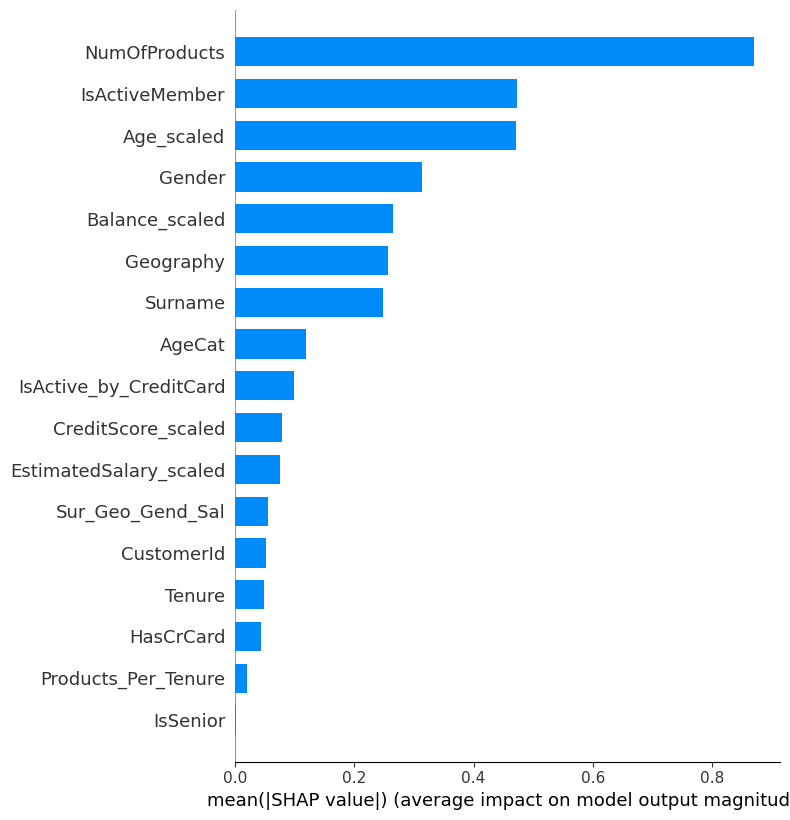

In [114]:
import shap # package used to calculate Shap values.
shap.initjs() 
explainer=shap.TreeExplainer(clf)
shap_values=explainer.shap_values(train_pool) 
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [127]:
y_pred=test_preds.mean(axis=0)
df_sub['Exited']=y_pred
df_sub.head()

,id,Exited
0,165034,0.013305
1,165035,0.843959
2,165036,0.014214
3,165037,0.194633
4,165038,0.420469


In [128]:
df_sub.to_csv('sub_catboost.csv',index=False)

### Prediction override

In [155]:
df_org=pd.read_csv('Churn_Modelling.csv')
join_cols=df_org.columns.drop(['RowNumber','Exited']).tolist()
df_org.rename(columns={'Exited':'Exited_org'},inplace=True)
df_org["Exited_org"]=df_org["Exited_org"].map({1:0,0:1})

df_test_ov=pd.read_csv('test.csv')
df_test_ov=df_test_ov.merge(df_org,on=join_cols,how='left')[['id','Exited_org']].fillna(-1)

df_sub=df_test_ov[['id','Exited_org']]

USE_DATA_LEAK=True

if USE_DATA_LEAK:
    df_sub['Exited']=np.where(df_sub["Exited_org"]==-1,y_pred,df_sub["Exited_org"]) # if -1 then use the prediction
else:
    df_sub['Exited']=y_pred

df_sub.drop(columns=['Exited_org'],axis=1,inplace=True)
df_sub.to_csv('sub_catboost_predOveride.csv',index=False)

In [156]:
np.mean(auc_vals)

0.8981402532066726